In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import cv2
from skimage import io
import seaborn as sns

from tqdm import tqdm
import os

# Generate src mask/boundary images to extract the shape

src_mask: 


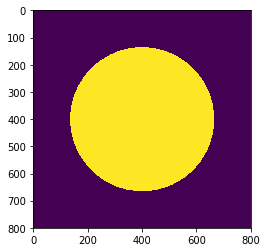

src_boundary: 


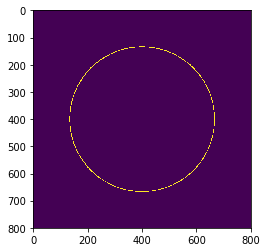

src_mask + src_boundary: 


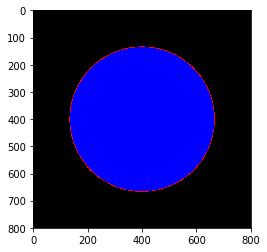

In [2]:
h, w = 800, 800

src_mask = np.zeros(shape=[h, w], dtype=np.uint8)
radius = min(h, w) // 3
cv2.circle(src_mask, (w // 2, h // 2), radius, (255, ), -1)
src_mask = src_mask.astype(bool)

src_boundary = np.zeros(shape=[h, w], dtype=np.uint8)
thickness = 2
cv2.circle(src_boundary, (w // 2, h // 2), radius, (255, ), thickness)
src_boundary = src_boundary.astype(bool)

src_mask[src_boundary] = False

print("src_mask: "); plt.imshow(src_mask); plt.show()
print("src_boundary: "); plt.imshow(src_boundary); plt.show()


# Composite mask + boundary just for visualization
mask_boundary_composite = np.zeros(shape=[h, w, 3], dtype=np.uint8)
mask_boundary_composite[src_boundary] = np.array([255, 0, 0])
mask_boundary_composite[src_mask] = np.array([0, 0, 255])

print("src_mask + src_boundary: "); plt.imshow(mask_boundary_composite); plt.show()

# Extract the shape from the boundary / mask images

In [3]:
def apply_least_square_fit(x, y):
    
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    s_xy = (x - x_mean) @ (y - y_mean)
    s_xx = (x - x_mean) @ (x - x_mean)
    
    if s_xx == 0:
        return None
    
    a = s_xy / s_xx
    b = y_mean - a * x_mean
    
    return a, b

In [4]:
def extract_shape_on_patch(mask_patch, boundary_patch):
    
    h, w = mask_patch.shape
    boundary_ys, boundary_xs = np.where(boundary_patch)
    
    ret = apply_least_square_fit(boundary_xs, boundary_ys)
    
    mask_count_lower, mask_count_uppper = 0, 0
    
    if ret is not None:
        a, b = ret
        theta = np.arctan(a) + np.pi / 2.0
        
        for x in range(w):
            y_thresh = a * x + b
            
            for y in range(h):
                if y > y_thresh:
                    mask_count_uppper += int(mask_patch[y, x])
                elif y < y_thresh:
                    mask_count_lower += int(mask_patch[y, x])
                else:
                    continue
    
    else:
        theta = np.pi
        
        x_thresh = np.mean(boundary_xs)
        
        for y in range(h):
            for x in range(w):
                
                if x < x_thresh:
                    mask_count_uppper += int(mask_patch[y, x])
                elif x > x_thresh:
                    mask_count_lower += int(mask_patch[y, x])
                else:
                    continue
                    
        
    if mask_count_lower > mask_count_uppper:
        theta -= np.pi
    
    # Normalize from (-180.0 ~ 180.0) to (0 ~ 360.0)
    if theta < 0.0:
        theta += 2.0 * np.pi
    
    return np.degrees(theta)

In [5]:
def extract_shape(mask_img, boundary_img, patch_size=80):
    
    h, w = mask_img.shape
    shape_img = np.empty(shape=[h, w], dtype=np.float64)
    shape_img[np.logical_not(boundary_img)] = None
    
     # Create padded images for later
    pad = patch_size // 2
    
    mask_img_padded = np.zeros(shape=[h + patch_size, w + patch_size], dtype=bool)
    mask_img_padded[pad:-pad, pad:-pad] = mask_img
    
    boundary_img_padded = np.zeros(shape=[h + patch_size, w + patch_size], dtype=bool)
    boundary_img_padded[pad:-pad, pad:-pad] = boundary_img
    
    # Extract all points on the boundary and fit a line for each point 
    # based on the distribution of boudary/mask points on the patch cropped around the point
    boundary_ys, boundary_xs = np.where(boundary_img)
    
    for patch_center_x, patch_center_y in tqdm(zip(boundary_xs, boundary_ys)):
        left = patch_center_x - patch_size // 2
        top = patch_center_y - patch_size // 2
        right = left + patch_size
        bottom = top + patch_size
        
        mask_patch = mask_img_padded[top+pad:bottom+pad, left+pad:right+pad]
        boundary_patch = boundary_img_padded[top+pad:bottom+pad, left+pad:right+pad]
        
        shape = extract_shape_on_patch(mask_patch, boundary_patch)
        shape_img[patch_center_y, patch_center_x] = shape
    
    return shape_img


shape_img = extract_shape(src_mask, src_boundary)

print("{} [deg] ~ {} [deg]".format( shape_img[src_boundary].min(), shape_img[src_boundary].max() ))

4972it [00:52, 111.01it/s]

6.198095403585808 [deg] ~ 353.77325518771835 [deg]


# Visualize the extracted shape

In [6]:
color_num = 6
palette = sns.hls_palette(color_num)

palette_byte = np.empty(shape=[0, 3], dtype=np.uint8)
for color in palette:
    color_byte = np.array([[int(color[0] * 255.0), int(color[1] * 255.0), int(color[2] * 255.0)]])
    palette_byte = np.append(palette_byte, color_byte, axis=0)

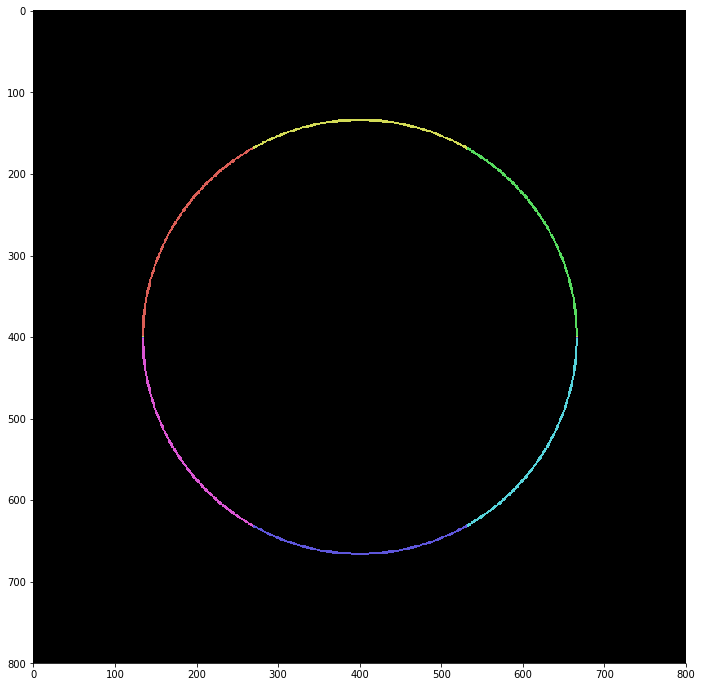

0[deg]  <----------------------------------------------------> 360[deg]


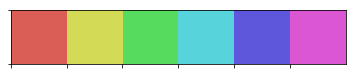

In [7]:
def colorize_shape(shape_img, boundary_img, color_num):
    
    # Prepare HLS color palette
    palette = sns.hls_palette(color_num)
    
    palette_byte = np.empty(shape=[0, 3], dtype=np.uint8)
    for color in palette:
        color_byte = np.array([[int(color[0] * 255.0), int(color[1] * 255.0), int(color[2] * 255.0)]])
        palette_byte = np.append(palette_byte, color_byte, axis=0)
    
    
    # Colorize
    h, w = shape_img.shape
    shape_colorized = np.zeros(shape=[h, w, 3], dtype=np.uint8)
    
    color_idxs = (shape_img[boundary_img]  / (360.0 - 0.0) * float(color_num)).astype(int)
    shape_colorized[boundary_img] = palette_byte[color_idxs]
    
    shape_colorized[np.logical_not(boundary_img)] = 0
    
    return shape_colorized


shape_colorized = colorize_shape(shape_img, src_boundary, 6)

plt.figure(figsize=(12,12))
plt.imshow(shape_colorized)
plt.show()

sns.palplot(palette)
print("0[deg]  <----------------------------------------------------> 360[deg]")